In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv("Data/Unipol_dataset_lab3.csv")
data_f_dist = data[data["total_distance"] > 0.0]#distances equal to 0 are an outlier
print(data_f_dist.shape)
data_f_dist = data_f_dist[~((data_f_dist["total_distance"] <0.1) & (data_f_dist["road"] == "A"))]#removes 50ish trips



(1249353, 7)


In [ ]:
data_f_dist.shape[0]

(1249058, 7)

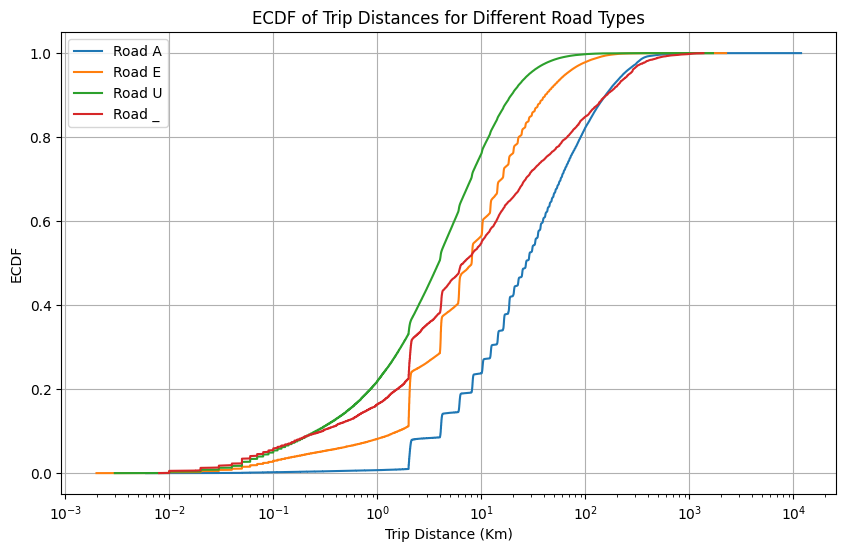

"\nFrom the ECDF plot:\n- Road type 'E' has a wider range of distances, with several long trips (up to ~14 km).\n- Road type 'U' primarily has shorter trips, with most distances under 2 km.\n- The step-like patterns in the ECDF indicate discrete trip distances.\n- Road type 'U' has more variability at shorter distances, while road 'E' includes outliers for longer trips.\n"

In [44]:
grouped = data_f_dist.groupby("road")
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x)+1) / len(x)
    return x, y

plt.figure(figsize=(10, 6))

for road, group in grouped:
    x, y = ecdf(group["total_distance"])
    plt.semilogx(x, y, label=f"Road {road}")

plt.xlabel("Trip Distance (Km)")
plt.ylabel("ECDF")
plt.title("ECDF of Trip Distances for Different Road Types")
plt.legend()
plt.grid(True)
plt.show()


"""
From the ECDF plot:
- Road type 'E' has a wider range of distances, with several long trips (up to ~14 km).
- Road type 'U' primarily has shorter trips, with most distances under 2 km.
- The step-like patterns in the ECDF indicate discrete trip distances.
- Road type 'U' has more variability at shorter distances, while road 'E' includes outliers for longer trips.
"""

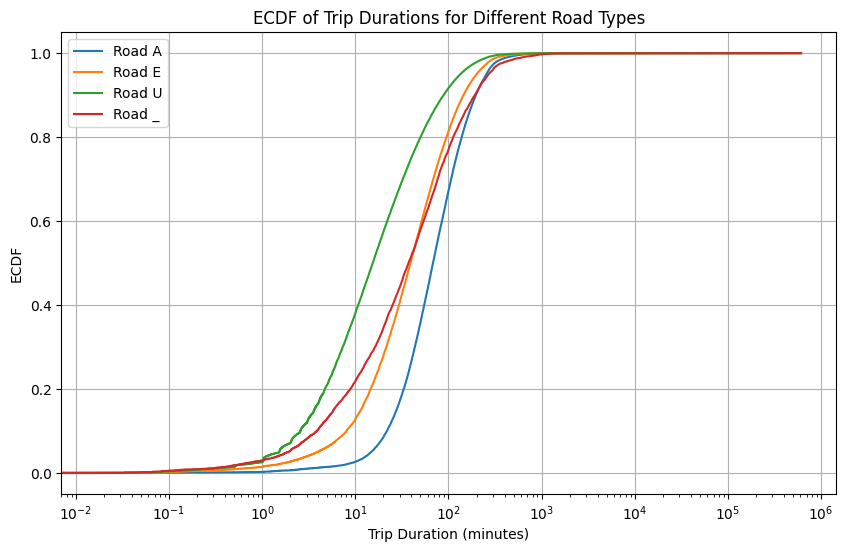

In [45]:

data_f_dist["start_time"] = pd.to_datetime(data_f_dist["start_time"])
data_f_dist["stop_time"] = pd.to_datetime(data_f_dist["stop_time"])
data_f_dist["trip_duration"] = (data_f_dist["stop_time"] - data_f_dist["start_time"]).dt.total_seconds() / 60.0 
grouped = data_f_dist.groupby("road")

plt.figure(figsize=(10, 6))
for road, group in grouped:
    x, y = ecdf(group["trip_duration"])
    plt.semilogx(x, y, label=f"Road {road}")

# Add labels, legend, and title
plt.xlabel("Trip Duration (minutes)")
plt.ylabel("ECDF")
plt.title("ECDF of Trip Durations for Different Road Types")
plt.legend()
plt.grid(True)
plt.show()

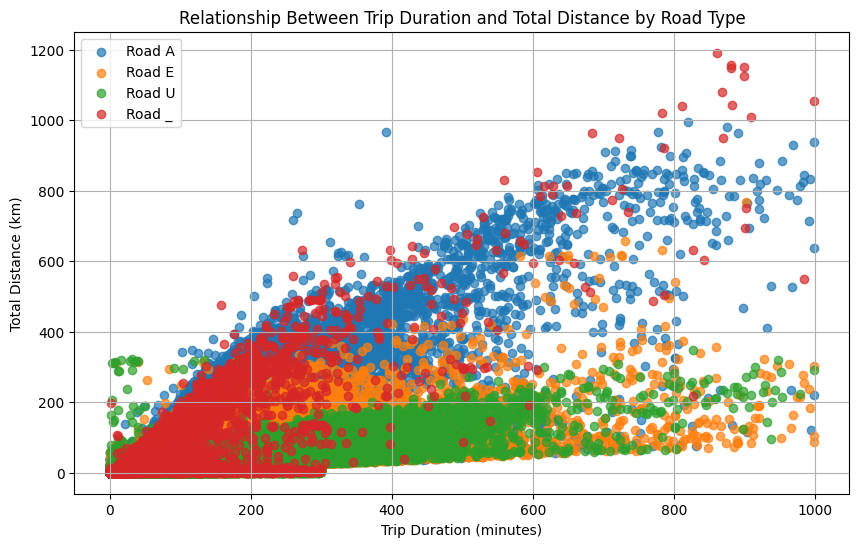

In [46]:
data_f_dist_avg = data_f_dist[~((data_f_dist["total_distance"] / (data_f_dist["trip_duration"] / 60) <= 10) & (data_f_dist["trip_duration"] > 600))]#removes 100ish trips
data_f_dist_avg = data_f_dist[~((data_f_dist["total_distance"] / (data_f_dist["trip_duration"] / 60) <= 5) & (data_f_dist["trip_duration"] > 300))]#removes 50ish trips

#data = data[data["trip_duration"] < 2880]#remove duration grate than 48 hours
data_f_dist_avg_dur = data_f_dist_avg[data_f_dist_avg['trip_duration'] < 1000]#remove duration grate than 24 hours 
plt.figure(figsize=(10, 6))
for road_type, group in data_f_dist_avg_dur.groupby("road"):
    plt.scatter(group["trip_duration"], group["total_distance"], label=f"Road {road_type}", alpha=0.7)

plt.xlabel("Trip Duration (minutes)")
plt.ylabel("Total Distance (km)")
plt.title("Relationship Between Trip Duration and Total Distance by Road Type")
plt.legend()
plt.grid(True)
plt.show()

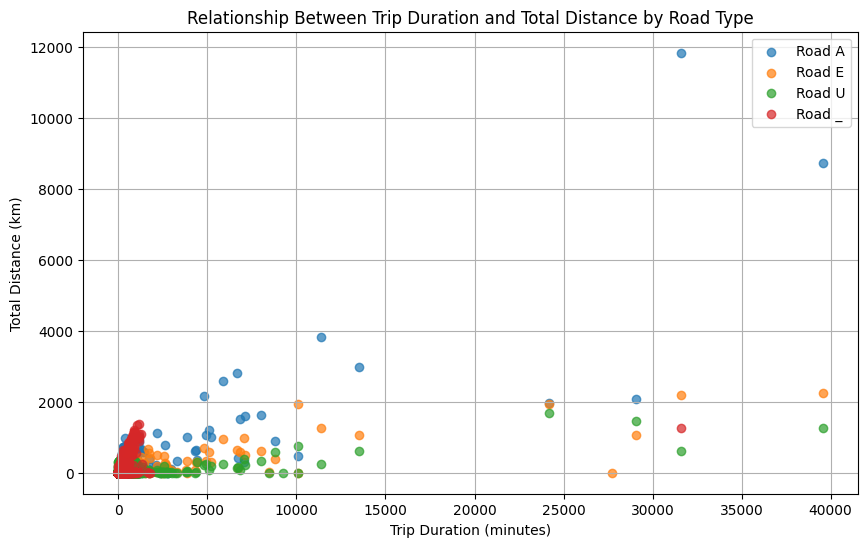

In [17]:
data_f_dist = data_f_dist[data_f_dist['trip_duration'] < 100000]#remove duration grate than 24 hours
plt.figure(figsize=(10, 6))
for road_type, group in data_f_dist.groupby("road"):
    plt.scatter(group["trip_duration"], group["total_distance"], label=f"Road {road_type}", alpha=0.7)

plt.xlabel("Trip Duration (minutes)")
plt.ylabel("Total Distance (km)")
plt.title("Relationship Between Trip Duration and Total Distance by Road Type")
plt.legend()
plt.grid(True)
plt.show()


In [27]:
nonFiltered_count = data.groupby(["vehicle_id", "trip_id"]).nunique().shape[0]
print(f"Number of trips before filtering: {nonFiltered_count}")

Number of trips before filtering: 966000


In [47]:
fil_dist_avg_dur_count = data_f_dist_avg_dur.groupby(["vehicle_id", "trip_id"]).nunique().shape[0]
print(f"Number of trips after filtering for average distance and duration: {fil_dist_avg_dur_count}")

Number of trips after filtering for average distance and duration: 828159


In [61]:
data_f_dist.groupby(["vehicle_id", "trip_id"]).nunique().shape[0]


828160

# Task 1

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv("Data/Unipol_dataset_lab3.csv")
data = data[data["total_distance"] > 0.0]
data = data[~((data["total_distance"] <0.1) & (data["road"] == "A"))]

data["start_time"] = pd.to_datetime(data["start_time"])
data["stop_time"] = pd.to_datetime(data["stop_time"])
data["trip_duration"] = (data["stop_time"] - data["start_time"]).dt.total_seconds() / 60.0 

data = data[~((data_f_dist["total_distance"] / (data["trip_duration"] / 60) <= 10) & (data["trip_duration"] > 600))]#removes 100ish trips
data = data[~((data_f_dist["total_distance"] / (data["trip_duration"] / 60) <= 5) & (data["trip_duration"] > 300))]#removes 50ish trips
data = data[data['trip_duration'] < 1200]#remove duration grate than 1200 minutes, 20 hours

#Number of trips before filtering: 966000 
print(data.shape[0], data.groupby(["vehicle_id", "trip_id"]).nunique().shape[0])

/var/folders/19/lzfqqvgn4vb6_yp4z23nnm_80000gn/T/ipykernel_33465/1146658673.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = data[~((data_f_dist["total_distance"] / (data["trip_duration"] / 60) <= 5) & (data["trip_duration"] > 300))]#removes 50ish trips


1243568 827889


In [67]:


data["date"] = data["start_time"].dt.date
aggregated = data.groupby(["vehicle_id", "date"]).agg(
    number_of_trips=("trip_id", "nunique"),
    total_travel_distance=("total_distance", "sum"),
    total_driving_time=("trip_duration", "sum")
).reset_index()
aggregated["utilization_percentage"] = aggregated["total_driving_time"] / (24 * 60) * 100  # Fraction of driving time in 24 hours

aggregated["day_of_week"] = pd.to_datetime(aggregated["date"]).dt.dayofweek
aggregated["is_weekend"] = aggregated["day_of_week"].isin([5, 6])

workday_stats = aggregated[~aggregated["is_weekend"]].describe()
weekend_stats = aggregated[aggregated["is_weekend"]].describe()

print("Workday Statistics:")
print(workday_stats)
print("\nWeekend Statistics:")
print(weekend_stats)

Workday Statistics:
         vehicle_id  number_of_trips  total_travel_distance  \
count  41754.000000     41754.000000           41754.000000   
mean     499.000216        15.364827             394.703687   
std      288.861591        16.464647             252.380491   
min        1.000000         1.000000               0.010000   
25%      249.000000         7.000000             226.990000   
50%      498.000000        12.000000             338.090000   
75%      749.000000        19.000000             520.075000   
max     1000.000000       612.000000            2113.090000   

       total_driving_time  utilization_percentage   day_of_week  
count        41754.000000            41754.000000  41754.000000  
mean          1125.847461               78.183851      1.960387  
std            551.480354               38.297247      1.397762  
min              0.000000                0.000000      0.000000  
25%            769.291667               53.423032      1.000000  
50%           11

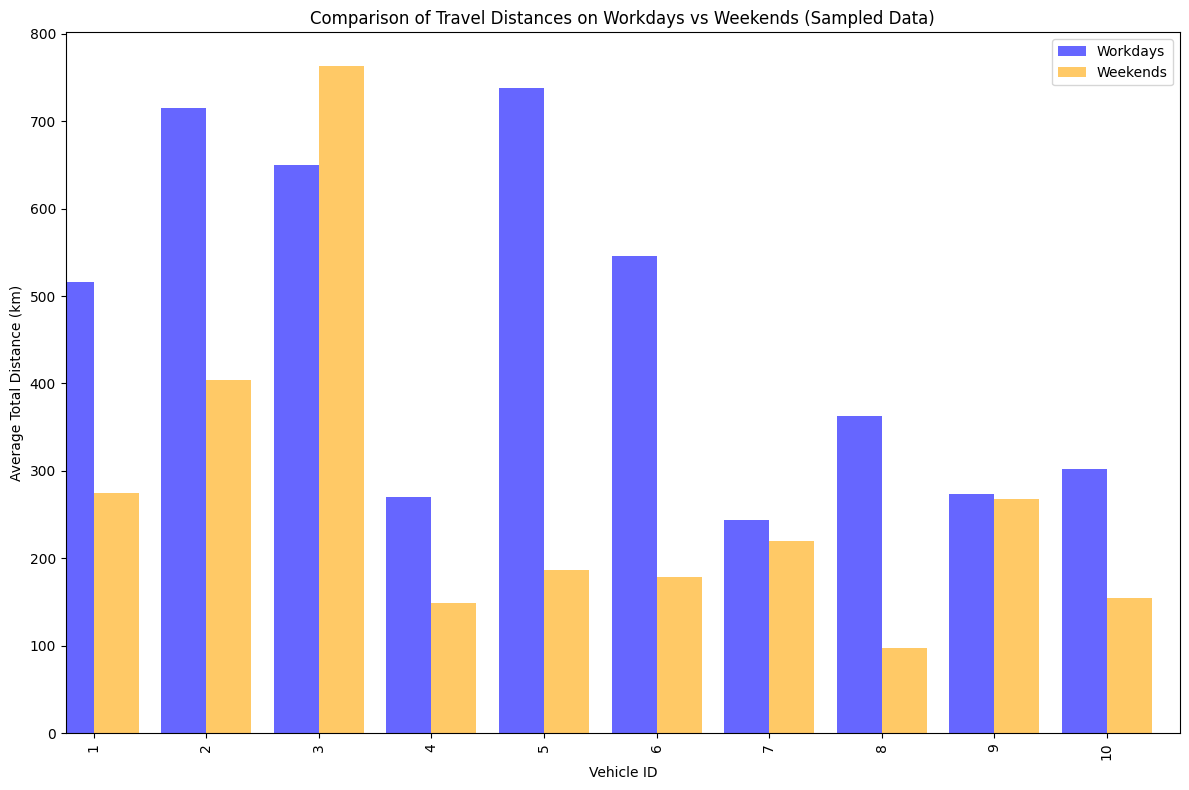

In [98]:
fig, ax = plt.subplots(figsize=(12, 8))
workday_data = aggregated[~aggregated["is_weekend"]].groupby("vehicle_id")["total_travel_distance"].mean()
weekend_data = aggregated[aggregated["is_weekend"]].groupby("vehicle_id")["total_travel_distance"].mean()
weekend_data = weekend_data.reindex(aggregated["vehicle_id"].unique(), fill_value=0)
workday_data = workday_data.reindex(aggregated["vehicle_id"].unique(), fill_value=0)
workday_data[0:10].plot(kind="bar", color="blue", alpha=0.6, position=1, width=0.4, label="Workdays", ax=ax)
weekend_data[0:10].plot(kind="bar", color="orange", alpha=0.6, position=0, width=0.4, label="Weekends", ax=ax)

ax.set_title("Comparison of Travel Distances on Workdays vs Weekends (Sampled Data)")
ax.set_ylabel("Average Total Distance (km)")
ax.set_xlabel("Vehicle ID")
ax.legend()
plt.tight_layout()
plt.show()

In [100]:
vehicles_higher_weekdays = (workday_data > weekend_data).sum()
total_vehicles = len(workday_data)
percentage_higher_weekdays = (vehicles_higher_weekdays / total_vehicles) * 100

print(f"Percentage of vehicles with higher average distance on weekdays: {percentage_higher_weekdays:.2f}%")


Percentage of vehicles with higher average distance on weekdays: 64.96%


In [ ]:
workday_data[630]

array([515.91762222, 714.82045455, 649.6585122 , 270.06772727,
       737.85444444, 546.30422727, 243.27363636, 362.35931818,
       273.88325581, 302.66      , 358.83534884, 353.21022727,
       743.22782051, 282.02863636, 280.95181818, 467.7630303 ,
       277.06595745, 593.92222222, 612.25878049, 245.81522727,
       384.05794872, 240.12906977, 311.20545455, 566.21190476,
       344.58840909, 370.16340909, 233.72363636, 239.09465116,
       522.17613636, 214.30772727, 496.43885714, 404.52675   ,
       581.235     , 472.90727273, 212.29465116, 611.49238095,
       261.02261905, 305.45454545, 679.31325581, 624.75225   ,
       219.92454545, 608.04977273, 280.08659091, 624.90785714,
       689.43418605, 405.21744186, 306.41977273, 318.71302326,
       208.91045455, 709.45045455, 348.21666667, 466.90681818,
       341.1575    , 658.49534884, 476.85241379, 512.05      ,
       387.33744186, 306.95348837, 291.05136364, 289.67465116,
       560.90848837, 697.29333333, 493.5505122 , 386.11

In [93]:
weekend_data[630]

204.7

# Task 2

1. Tesla model 3 range: 420km
2. BMW iX xDrive40 range: 360km
3. Citroen e-C3  range: 260km



Evaluation Metrics
1. Percentage of Feasible Trips 
2. Energy Consumption per 100 km
3. Charging time